In [77]:
import os
import operator
from dotenv import load_dotenv
from typing import Annotated, List, Optional
from typing_extensions import TypedDict
from IPython.display import Image

from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage
from langgraph.graph import StateGraph, START, END
from langchain_core.tools import tool


load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="llama3-70b-8192", api_key = groq_api_key)


In [78]:
class TripRequest(BaseModel) :
    """Schema for user's travel requests."""
    destination : str = Field(description= "The city or country for the trip.")
    days : int = Field(description= "The total number of days for the trip.")
    person : int = Field(description= "The total number of person who participate the trip")
    budget : Optional[float] = Field(description= "The estimated budget for the trip") 
    interests : Optional[List[str]] = Field(description= "A list of interests for the trip, e.g., []'art', 'history', 'food']." )
    

In [86]:
class FlightInfo(BaseModel) :
    """Schema for flight information"""
    airline : str = Field(description= "The name of the airline")
    price : float = Field(description= "The price of the round-trip flight")
    origin : str = Field(description= "The departure city")
    destination : str = Field(description= "The arrival city")


class HotelInfo(BaseModel):
    """Schema for hotel information."""
    hotel_name: str = Field(description="The name of the hotel.")
    price_per_night: float = Field(description="The price per night.")
    total_price: float = Field(description="The total price for the entire stay.")
    rating: float = Field(description="The hotel's rating out of 5.")

In [ ]:
@tool
def flight_search_tool(destination: str, person: int) -> FlightInfo:
    """
    Searches for flights for a given destination and number of persons.
    This is a mock tool and returns dummy data.
    """
    print(f"--- Calling Flight Search Tool for {destination} for {person} people ---")
    
    base_price_per_person = 750.0
    total_price = base_price_per_person * person
    
    return FlightInfo(
        airline="Turkish Airlines",
        price=total_price,
        origin="Antalya",
        destination=destination
    )


@tool
def hotel_search_tool(destination: str, days: int, person: int) -> HotelInfo:
    """
    Searches for hotels for a given destination, duration, and number of people.
    This is a mock tool and returns dummy data.
    """
    print(f"--- Calling Hotel Search Tool for {destination} for {person} people ---")
    price_per_night = 150.0 * (person / 2) 
    total_price = price_per_night * (days - 1) 
    return HotelInfo(hotel_name="Grand Royale Hotel", price_per_night=price_per_night, total_price=total_price, rating=4.5)

In [88]:
class TripState(TypedDict):
    user_request: str
    trip_plan: Optional[TripRequest]
    flight_info: Optional[FlightInfo]
    hotel_info: Optional[HotelInfo]

In [82]:
def planner_agent(state: TripState) -> dict:
    """
    Takes the user request and converts it into a structured TripRequest object.
    """
    print("--- Running Planner Agent ---")
    
    structured_llm = llm.with_structured_output(TripRequest)
    
    prompt = f"""
    Parse the following user request into a structured TripRequest object.
    Identify the destination, number of days, budget, and key interests.

    User Request: "{state['user_request']}"
    """
    
    plan = structured_llm.invoke(prompt)
    print(f"-> Structured Plan: {plan}")
    
    return {"trip_plan": plan}

In [90]:
def flight_agent(state: TripState) -> dict:
    """
    Takes the structured trip plan and uses the flight search tool to find flights.
    """
    print("--- Running Flight Agent ---")
    trip_plan = state['trip_plan']
    if not trip_plan:
        return {}


    flight_data = flight_search_tool.invoke({
        "destination": trip_plan.destination,
        "person": trip_plan.person
    })
    print(f"-> Flight Info: {flight_data}")

    return {"flight_info": flight_data}



def hotel_agent(state: TripState) -> dict:
    """
    Takes the structured trip plan and uses the hotel search tool to find hotels.
    """
    print("--- Running Hotel Agent ---")
    trip_plan = state['trip_plan']
    if not trip_plan: return {}
    hotel_data = hotel_search_tool.invoke({
        "destination": trip_plan.destination,
        "days": trip_plan.days,
        "person": trip_plan.person
    })
    print(f"-> Hotel Info: {hotel_data}")
    return {"hotel_info": hotel_data}

In [91]:
def aggregator_agent(state: TripState) -> dict:
    """
    Aggregates the results from parallel agents.
    """
    print("--- Running Aggregator Agent ---")
    print("-> Aggregated Flight Info:", state.get('flight_info'))
    print("-> Aggregated Hotel Info:", state.get('hotel_info'))
    return {}

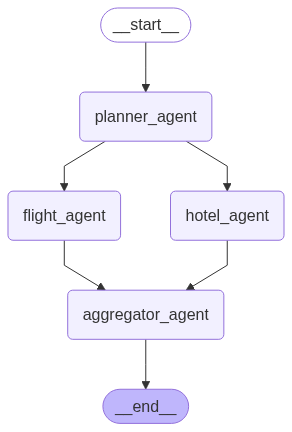

In [92]:
workflow = StateGraph(TripState)


workflow.add_node("planner_agent", planner_agent)
workflow.add_node("flight_agent", flight_agent)
workflow.add_node("hotel_agent", hotel_agent) 
workflow.add_node("aggregator_agent", aggregator_agent) 


workflow.add_edge(START, "planner_agent")

workflow.add_edge("planner_agent", "flight_agent")
workflow.add_edge("planner_agent", "hotel_agent")

workflow.add_edge(["flight_agent", "hotel_agent"], "aggregator_agent")

workflow.add_edge("aggregator_agent", END)


app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [93]:
user_query = "I want to plan a 5-day trip to Rome with my girlfriend . I'm interested in history and food, and my budget is around 1500 euro."
initial_state = {"user_request": user_query}

final_state = app.invoke(initial_state)

print("\n--- FINAL STATE ---")
print(final_state)

--- Running Planner Agent ---
-> Structured Plan: destination='Rome' days=5 person=2 budget=1500.0 interests=['history', 'food']
--- Running Flight Agent ---
--- Calling Flight Search Tool for Rome for 2 people ---
-> Flight Info: airline='Turkish Airlines' price=1500.0 origin='Antalya' destination='Rome'
--- Running Hotel Agent ---
--- Calling Hotel Search Tool for Rome for 2 people ---
-> Hotel Info: hotel_name='Grand Royale Hotel' price_per_night=150.0 total_price=600.0 rating=4.5
--- Running Aggregator Agent ---
-> Aggregated Flight Info: airline='Turkish Airlines' price=1500.0 origin='Antalya' destination='Rome'
-> Aggregated Hotel Info: hotel_name='Grand Royale Hotel' price_per_night=150.0 total_price=600.0 rating=4.5

--- FINAL STATE ---
{'user_request': "I want to plan a 5-day trip to Rome with my girlfriend . I'm interested in history and food, and my budget is around 1500 euro.", 'trip_plan': TripRequest(destination='Rome', days=5, person=2, budget=1500.0, interests=['history